# ДЗ №2. Вычислительная математика.
## Выполнил студент 772 группы Усеинов Булат

### Подготовим среду для решения задачи.

In [37]:
import numpy as np
import os
import sys
import time
import pandas as pd 
from tqdm._tqdm_notebook import tqdm_notebook
import pickle
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from keras import optimizers
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import logging
from matplotlib import pyplot as plt
from keras.utils import plot_model
from IPython.display import Image

In [3]:
params = {
    "batch_size": 20,
    "epochs": 300,
    "lr": 0.00010000,
    "time_steps": 60
}

iter_changes = "dropout_layers_0.4_0.4_yandex_final"

INPUT_PATH = "/Users/bulat/edu/calc_math/HW_2/raw_data/"
OUTPUT_PATH = "/Users/bulat/edu/calc_math/HW_2/Output/"+iter_changes
TIME_STEPS = params["time_steps"]
BATCH_SIZE = params["batch_size"]

if not os.path.exists(OUTPUT_PATH):
    os.makedirs(OUTPUT_PATH)
    print("Directory created", OUTPUT_PATH)
else:
    raise Exception("Directory already exists. Don't override.")

Directory created /Users/bulat/edu/calc_math/HW_2/Output/dropout_layers_0.4_0.4_yandex_final


## I. Анализ данных и трансформация датасета.

In [4]:
data = pd.read_csv('Yandex_fullstock_data.csv')

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2145 entries, 0 to 2144
Data columns (total 6 columns):
Date           2145 non-null object
 Close/Last    2145 non-null object
 Volume        2145 non-null int64
 Open          2145 non-null object
 High          2145 non-null object
 Low           2145 non-null object
dtypes: int64(1), object(5)
memory usage: 100.6+ KB


In [6]:
data.head(5)

,Date,Close/Last,Volume,Open,High,Low
0,11/29/2019,$41.97,1990245,$41.34,$42.1,$41.33
1,11/27/2019,$41.81,1629502,$41.34,$41.905,$41.34
2,11/26/2019,$41.47,2552003,$41.32,$41.6,$40.79
3,11/25/2019,$41.07,2125477,$40.37,$41.48,$40.37
4,11/22/2019,$40.46,1755400,$40.18,$40.69,$40.01


In [7]:
def convert_dollar_to_float(s):
    return float(s.replace('$',''))

data.rename(columns={" Close/Last":"Close", " Volume":"Volume", " Open":"Open", " High":"High", " Low":"Low"}, inplace=True)
data.Close = data.Close.apply(convert_dollar_to_float)
data.Open = data.Open.apply(convert_dollar_to_float)
data.High = data.High.apply(convert_dollar_to_float)
data.Low = data.Low.apply(convert_dollar_to_float)
data.Date = pd.to_datetime(data.Date)
data.sort_values(by = 'Date', inplace=True)
data.reset_index(inplace=True, drop = True)

In [8]:
data.head(5)

,Date,Close,Volume,Open,High,Low
0,2011-05-24,38.84,70156130,35.00,42.01,30.55
1,2011-05-25,35.00,11750020,37.75,37.90,34.40
2,2011-05-26,34.77,4415791,34.45,35.45,34.00
3,2011-05-27,34.45,2005954,34.75,35.00,34.00
4,2011-05-31,33.45,3979702,34.95,35.37,32.61


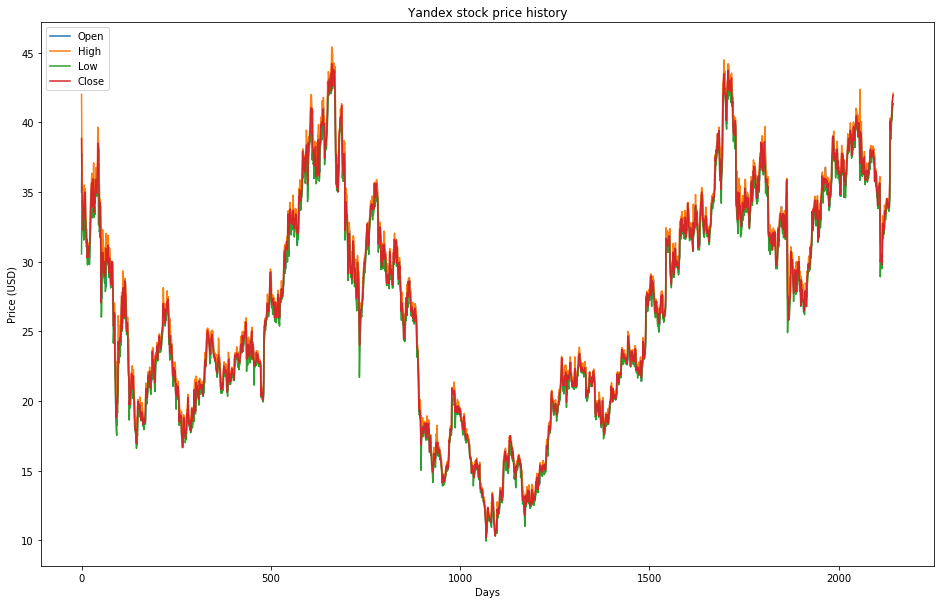

In [9]:
plt.figure(figsize=(16,10))
plt.plot(data["Open"])
plt.plot(data["High"])
plt.plot(data["Low"])
plt.plot(data["Close"])
plt.title('Yandex stock price history')
plt.ylabel('Price (USD)')
plt.xlabel('Days')
plt.legend(['Open','High','Low','Close'], loc='upper left')
plt.show()

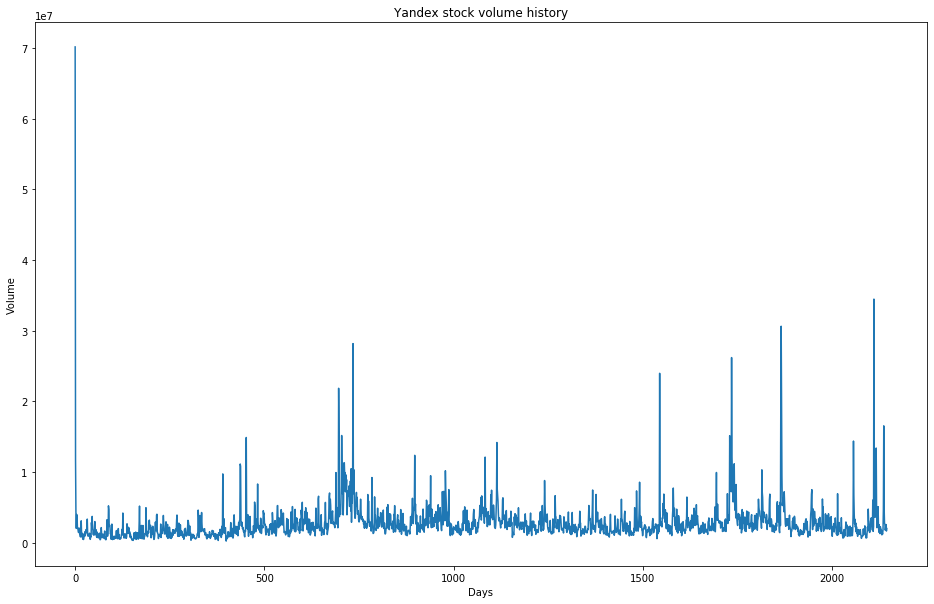

In [10]:
plt.figure(figsize=(16, 10))
plt.plot(data["Volume"])
plt.title('Yandex stock volume history')
plt.ylabel('Volume')
plt.xlabel('Days')
plt.show()

In [11]:
data.to_csv('data.csv', index=False)

In [12]:
data = pd.read_csv('data.csv')
data.head(3)

,Date,Close,Volume,Open,High,Low
0,2011-05-24,38.84,70156130,35.00,42.01,30.55
1,2011-05-25,35.00,11750020,37.75,37.90,34.40
2,2011-05-26,34.77,4415791,34.45,35.45,34.00


In [13]:
data = pd.DataFrame([data.Open, data.High, data.Low, data.Close, data.Volume]).transpose()

In [14]:
data.head(3)

,Open,High,Low,Close,Volume
0,35.00,42.01,30.55,38.84,70156130.0
1,37.75,37.90,34.40,35.00,11750020.0
2,34.45,35.45,34.00,34.77,4415791.0


## II. Подготовка данных к виду необходимому для решения задачи временных рядов.

In [15]:
train_cols = ["Open","High","Low","Close","Volume"]
df_train, df_test = train_test_split(data, train_size=0.8, test_size=0.2, shuffle=False)
print("Train--Test size", len(df_train), len(df_test))

Train--Test size 1716 429


### Нормализуем данные по минимальному и максимальному элементу. Минимальный станет 0, а максимальный 1.
$$X_{std} = \frac{X - \min(X)}{\max(X) - \min(X)}$$
$$X_{scaled} = X_{std} \cdot (max - min) + min$$

In [16]:
x = df_train.loc[:,train_cols].values
min_max_scaler = MinMaxScaler()
x_train = min_max_scaler.fit_transform(x)
x_test = min_max_scaler.transform(df_test.loc[:,train_cols])

### Объявим функции для подготовки данных

In [17]:
def trim_dataset(mat,batch_size):
    """
    Обрезает датасет, чтобы он делился нацело на BATCH_SIZE
    """
    no_of_rows_drop = mat.shape[0]%batch_size
    if no_of_rows_drop > 0:
        return mat[:-no_of_rows_drop]
    else:
        return mat


def build_timeseries(mat, y_col_index):
    """
    Конвертирует массив в формат временных рядов. Берет первые TIME_STEPS
    рядов как вход и обозначает TIME_STEPS+1-ый ряд как выход и тд.
    :param mat: матрица датасета
    :param y_col_index: индекс колонки в датасете отвечающей за целевую переменную
    :return: два списка которые можно скормить в LSTM как вход и выход
    """
    dim_0 = mat.shape[0] - TIME_STEPS
    dim_1 = mat.shape[1]
    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    y = np.zeros((dim_0,))
    print("dim_0",dim_0)
    for i in tqdm_notebook(range(dim_0)):
        x[i] = mat[i:TIME_STEPS+i]
        y[i] = mat[TIME_STEPS+i, y_col_index]
    print("length of time-series i/o",x.shape,y.shape)
    return x, y

In [18]:
print("Are any NaNs present in train/test matrices?",np.isnan(x_train).any(), np.isnan(x_train).any())
x_t, y_t = build_timeseries(x_train, 3)
x_t = trim_dataset(x_t, BATCH_SIZE)
y_t = trim_dataset(y_t, BATCH_SIZE)
print("Batch trimmed size",x_t.shape, y_t.shape)

Are any NaNs present in train/test matrices? False False
dim_0 1656



length of time-series i/o (1656, 60, 5) (1656,)
Batch trimmed size (1640, 60, 5) (1640,)


## III. Инициализация и обучение нейронной сети.

Будем пользоваться LSTM, т.к. эта архитектура лучше всего подходит для решения задач временных рядов. Градиент от давних элементов выражения затухает медленнее, т.е. сеть "помнит" информацию от более ранних вхождений.

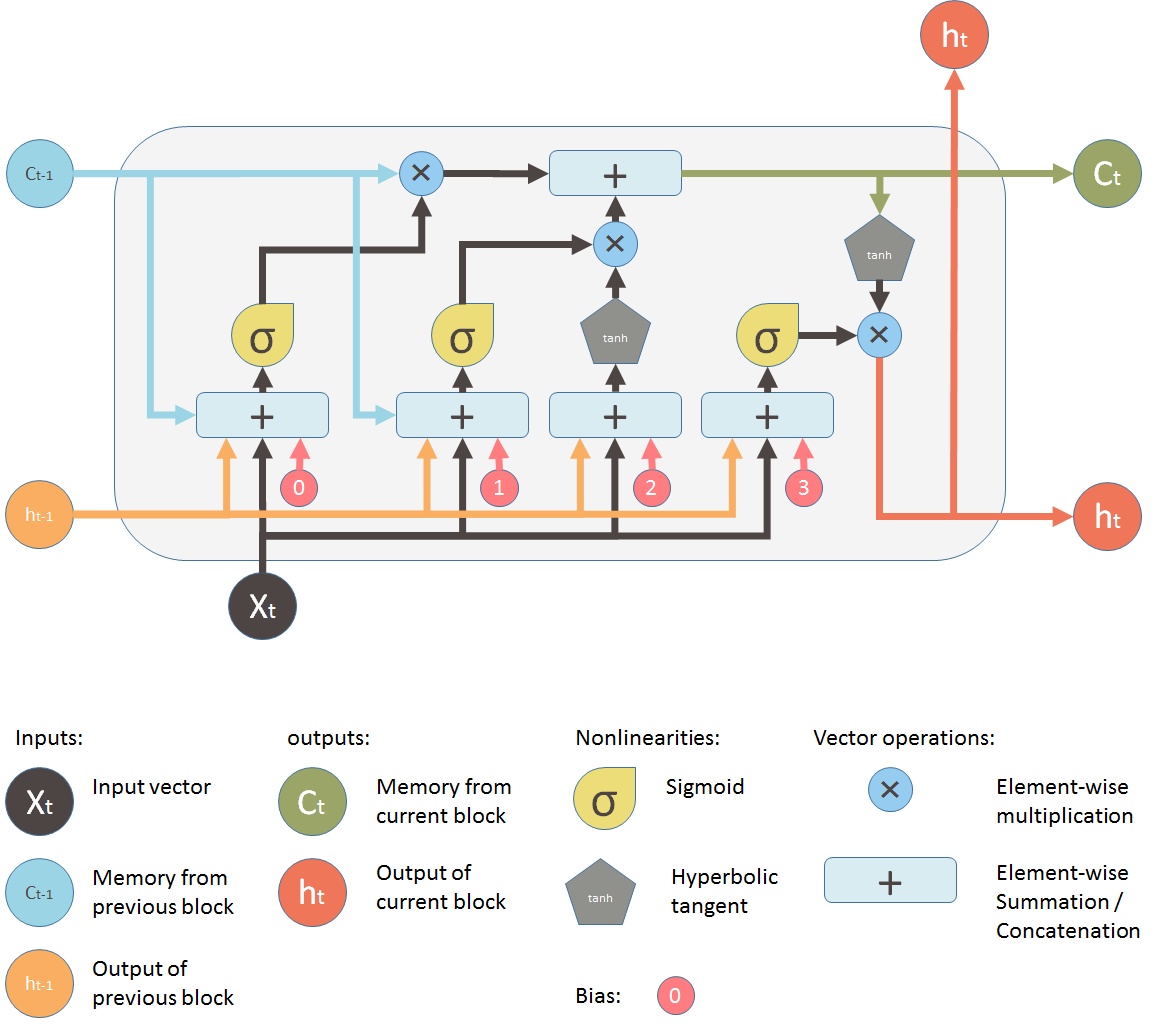

In [40]:
Image("./images/LSTM.png")

### Объявим архитектуру нейронной сети, которую будем обучать 

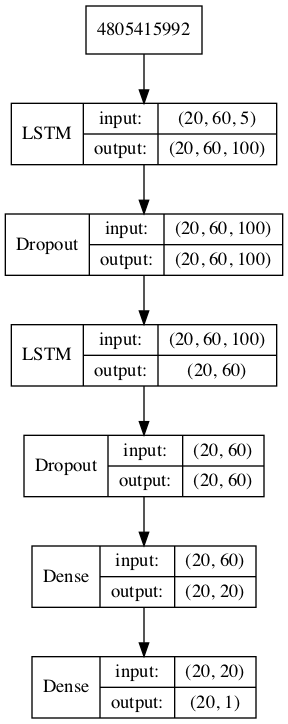

In [21]:
def create_model():
    lstm_model = Sequential()
    # (batch_size, timesteps, data_dim)
    lstm_model.add(LSTM(100, batch_input_shape=(BATCH_SIZE, TIME_STEPS, x_t.shape[2]),
                        dropout=0.0, recurrent_dropout=0.0, stateful=True, return_sequences=True,
                        kernel_initializer='random_uniform'))
    lstm_model.add(Dropout(0.4))
    lstm_model.add(LSTM(60, dropout=0.0))
    lstm_model.add(Dropout(0.4))
    lstm_model.add(Dense(20,activation='relu'))
    lstm_model.add(Dense(1,activation='sigmoid'))
    optimizer = optimizers.RMSprop(lr=params["lr"])
    # optimizer = optimizers.SGD(lr=0.000001, decay=1e-6, momentum=0.9, nesterov=True)
    lstm_model.compile(loss='mean_squared_error', optimizer=optimizer)
    return lstm_model


model = create_model()
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=False)
Image("model.png")

In [22]:
x_temp, y_temp = build_timeseries(x_test, 3)
x_val, x_test_t = np.split(trim_dataset(x_temp, BATCH_SIZE),2)
y_val, y_test_t = np.split(trim_dataset(y_temp, BATCH_SIZE),2)

dim_0 369



length of time-series i/o (369, 60, 5) (369,)


In [23]:
print("Test size", x_test_t.shape, y_test_t.shape, x_val.shape, y_val.shape)

Test size (180, 60, 5) (180,) (180, 60, 5) (180,)


### Обучим нейронную сеть.
- $\textit{loss}$ : MSE (Средне квадратичная ошибка)
- $\textit{optimizer}$ : RMSprop показал лучшие результаты, также используется $\textit{ReduceLROnPlateau}$

loss-функции, которые могут быть использованы для решения задачи регрессии:

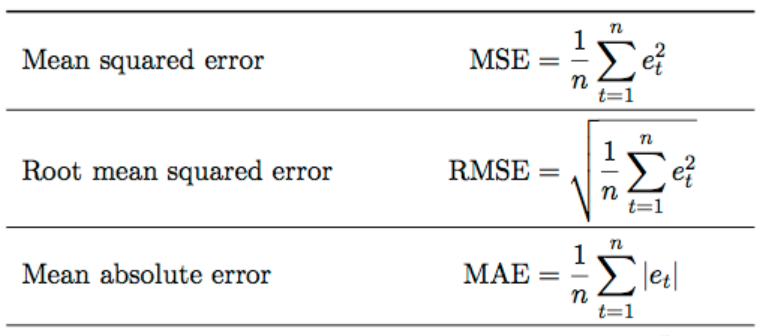

In [24]:
Image("./images/Loss_Functions.png")

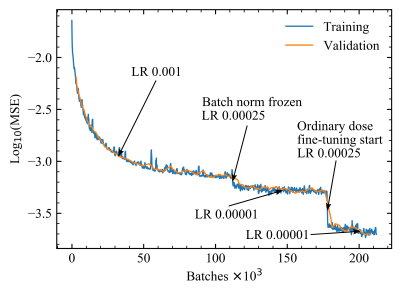

In [25]:
Image("./images/mse.png")

Оптимизатор RMSprop, который хорошо подошел для этой задачи

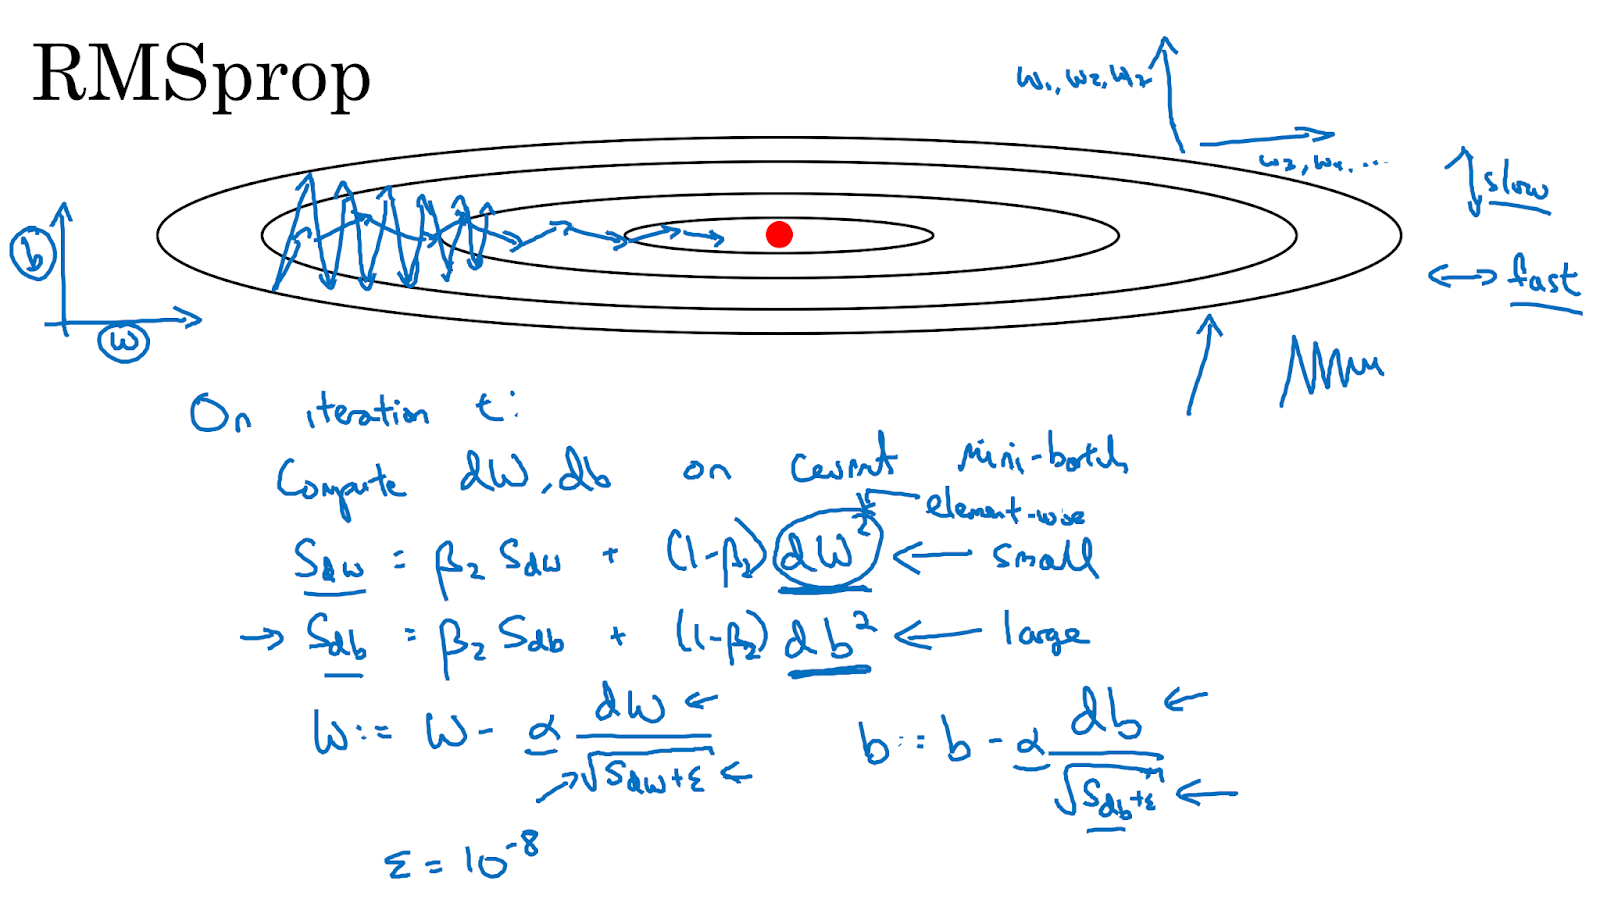

In [26]:
Image("./images/RMSprop.png")

In [27]:
is_update_model = True
if model is None or is_update_model:
    from keras import backend as K
    print("Building model...")
    print("checking if GPU available", K.tensorflow_backend._get_available_gpus())
    model = create_model()

    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,
                       patience=40, min_delta=0.0001)
    
    mcp = ModelCheckpoint(os.path.join(OUTPUT_PATH,
                          "best_model.h5"), monitor='val_loss', verbose=1,
                          save_best_only=True, save_weights_only=False, mode='min', period=1)

    r_lr_plat = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=20, 
                                  verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)
    
    csv_logger = CSVLogger(os.path.join(OUTPUT_PATH, 'training_log_' + time.ctime().replace(" ","_") + '.log'), append=True)
    
    history = model.fit(x_t, y_t, epochs=params["epochs"], verbose=2, batch_size=BATCH_SIZE,
                        shuffle=False, validation_data=(trim_dataset(x_val, BATCH_SIZE),
                        trim_dataset(y_val, BATCH_SIZE)), callbacks=[es, mcp, csv_logger, r_lr_plat])
    
    print("saving model...")
    pickle.dump(model, open("lstm_model", "wb"))

W1201 18:38:24.405090 4503582144 deprecation_wrapper.py:119] From /Users/bulat/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.



Building model...
checking if GPU available []


W1201 18:38:25.146493 4503582144 deprecation.py:323] From /Users/bulat/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 1640 samples, validate on 180 samples
Epoch 1/300
 - 5s - loss: 0.0519 - val_loss: 0.0334

Epoch 00001: val_loss improved from inf to 0.03336, saving model to /Users/bulat/edu/calc_math/HW_2/Output/dropout_layers_0.4_0.4_yandex_final/best_model.h5
Epoch 2/300
 - 4s - loss: 0.0498 - val_loss: 0.0309

Epoch 00002: val_loss improved from 0.03336 to 0.03090, saving model to /Users/bulat/edu/calc_math/HW_2/Output/dropout_layers_0.4_0.4_yandex_final/best_model.h5
Epoch 3/300
 - 4s - loss: 0.0454 - val_loss: 0.0271

Epoch 00003: val_loss improved from 0.03090 to 0.02710, saving model to /Users/bulat/edu/calc_math/HW_2/Output/dropout_layers_0.4_0.4_yandex_final/best_model.h5
Epoch 4/300
 - 4s - loss: 0.0346 - val_loss: 0.0124

Epoch 00004: val_loss improved from 0.02710 to 0.01244, saving model to /Users/bulat/edu/calc_math/HW_2/Output/dropout_layers_0.4_0.4_yandex_final/best_model.h5
Epoch 5/300
 - 4s - loss: 0.0153 - val_loss: 0.0060

Epoch 00005: val_loss improved from 0.01244 to 0

### Отоборазим кривые обучения

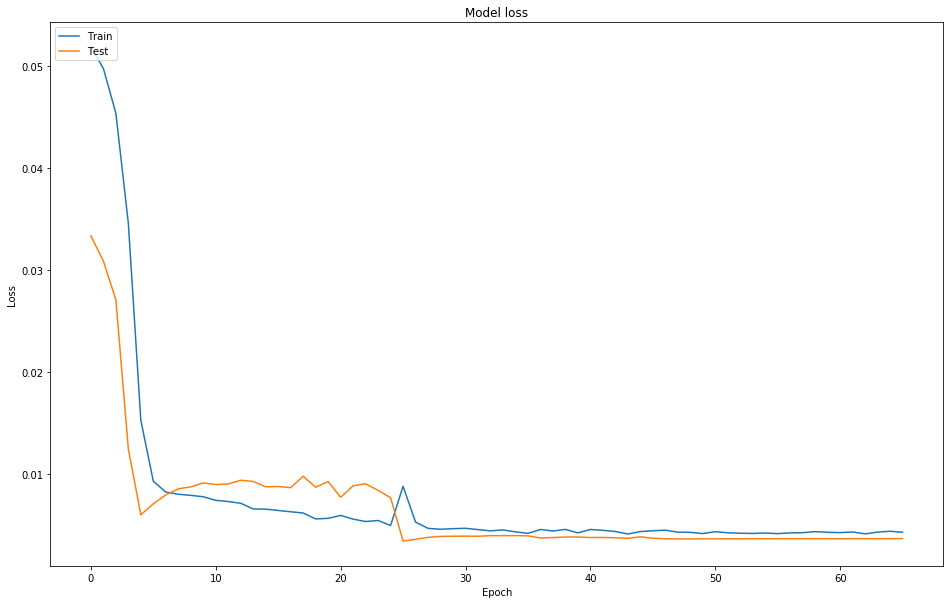

In [28]:
from matplotlib import pyplot as plt
plt.figure(figsize=(16,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
#plt.show()
plt.savefig(os.path.join(OUTPUT_PATH, 'train_vis_BS_'+str(BATCH_SIZE)+"_"+time.ctime()+'.png'))

## IV. Представление результатов

### Сделаем предсказние на тестовой выборке (модель не видела эти данные ни в каком виде)

In [29]:
saved_model = load_model(os.path.join(OUTPUT_PATH, 'best_model.h5')) # , "lstm_best_7-3-19_12AM",
print(saved_model)

In [30]:
y_pred = saved_model.predict(trim_dataset(x_test_t, BATCH_SIZE), batch_size=BATCH_SIZE)
y_pred = y_pred.flatten()
y_test_t = trim_dataset(y_test_t, BATCH_SIZE)
error = mean_squared_error(y_test_t, y_pred)
print("Error is", error, y_pred.shape, y_test_t.shape)
print(y_pred[0:15])
print(y_test_t[0:15])
y_pred_org = (y_pred * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3] # min_max_scaler.inverse_transform(y_pred)
y_test_t_org = (y_test_t * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3] # min_max_scaler.inverse_transform(y_test_t)
print(y_pred_org[0:15])
print(y_test_t_org[0:15])

Error is 0.0027452320441327246 (180,) (180,)
[0.70201933 0.7041162  0.70705944 0.71021426 0.7130946  0.71621585
 0.719431   0.72270864 0.7258136  0.7289022  0.7320683  0.73505574
 0.73775125 0.74011505 0.741958  ]
[0.76321974 0.75793184 0.7353114  0.73207991 0.75851939 0.74618096
 0.75029377 0.74941246 0.75793184 0.75763807 0.75646298 0.75146886
 0.75499412 0.73824912 0.75058754]
[34.076736 34.148117 34.248306 34.355694 34.453743 34.55999  34.669434
 34.781006 34.886696 34.991833 35.099606 35.201298 35.293053 35.37352
 35.436253]
[36.16 35.98 35.21 35.1  36.   35.58 35.72 35.69 35.98 35.97 35.93 35.76
 35.88 35.31 35.73]


### Сравним предсказанные цены закрытия биржи с реальными на тестовой выборке

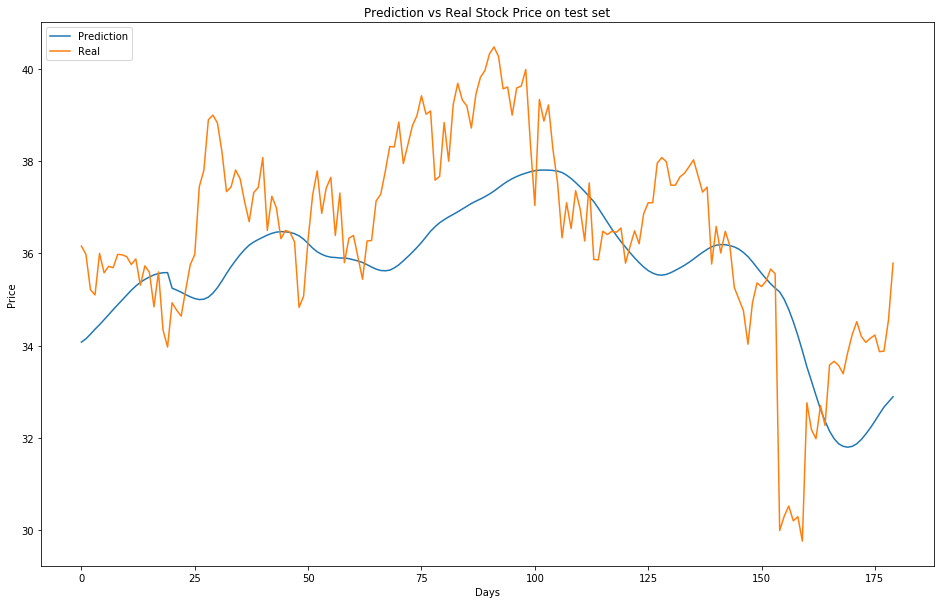

In [31]:
from matplotlib import pyplot as plt
plt.figure(figsize=(16,10))
plt.plot(y_pred_org)
plt.plot(y_test_t_org)
plt.title('Prediction vs Real Stock Price on test set')
plt.ylabel('Price')
plt.xlabel('Days')
plt.legend(['Prediction', 'Real'], loc='upper left')
#plt.show()
plt.savefig(os.path.join(OUTPUT_PATH, 'pred_vs_real_BS'+str(BATCH_SIZE)+"_"+time.ctime()+'.png'))

### Сделаем предсказние на всей выборке

In [32]:
x = data.loc[:,train_cols].values
min_max_scaler = MinMaxScaler()
x_t = min_max_scaler.fit_transform(x)

In [33]:
x_t, y_t = build_timeseries(x_t, 3)
x_t = trim_dataset(x_t, BATCH_SIZE)
y_t = trim_dataset(y_t, BATCH_SIZE)
print("Batch trimmed size",x_t.shape, y_t.shape)

dim_0 2085



length of time-series i/o (2085, 60, 5) (2085,)
Batch trimmed size (2080, 60, 5) (2080,)


In [34]:
y_pred = saved_model.predict(trim_dataset(x_t, BATCH_SIZE), batch_size=BATCH_SIZE)
y_pred = y_pred.flatten()
y_test_t = trim_dataset(y_t, BATCH_SIZE)
error = mean_squared_error(y_t, y_pred)
print("Error is", error, y_pred.shape, y_test_t.shape)
print(y_pred[0:15])
print(y_test_t[0:15])
y_pred_org = (y_pred * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3] # min_max_scaler.inverse_transform(y_pred)
y_test_t_org = (y_test_t * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3] # min_max_scaler.inverse_transform(y_test_t)
print(y_pred_org[0:15])
print(y_test_t_org[0:15])

Error is 0.004795466221875917 (2080,) (2080,)
[0.6541647  0.64318204 0.6321793  0.6218842  0.6107951  0.6004416
 0.592286   0.585349   0.57990456 0.57532585 0.57236165 0.5708854
 0.5698871  0.568287   0.5667305 ]
[0.5693302  0.5819624  0.55434783 0.55082256 0.61016451 0.59694477
 0.59547591 0.59253819 0.58108108 0.61075206 0.61721504 0.59341951
 0.55934195 0.57638073 0.58989424]
[32.44777  32.073917 31.699385 31.34894  30.971466 30.619032 30.341415
 30.105282 29.919952 29.764093 29.66319  29.61294  29.578959 29.52449
 29.471506]
[29.56 29.99 29.05 28.93 30.95 30.5  30.45 30.35 29.96 30.97 31.19 30.38
 29.22 29.8  30.26]


### Сравним предсказанные цены закрытия биржи с реальными на тестовой выборке

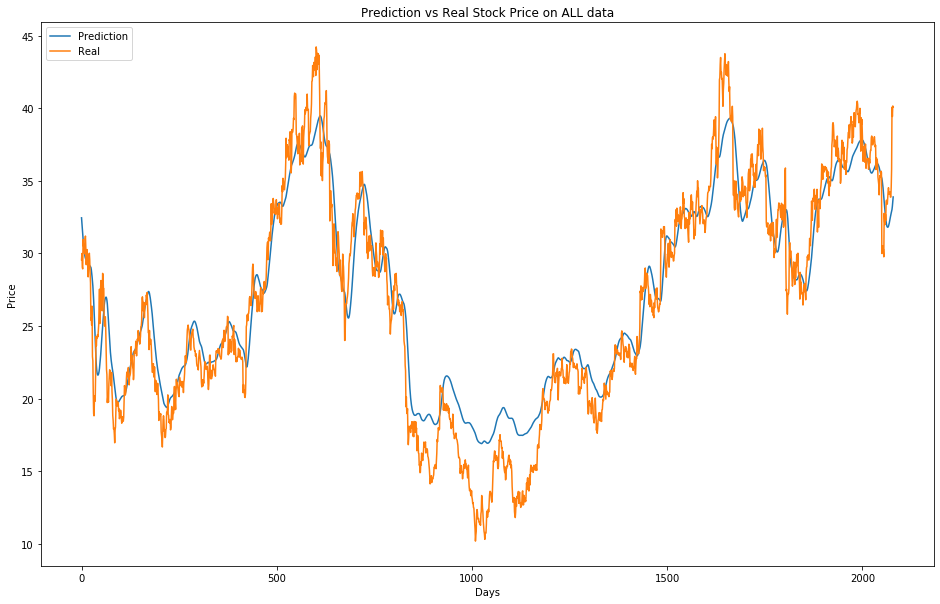

In [35]:
from matplotlib import pyplot as plt
plt.figure(figsize=(16,10))
plt.plot(y_pred_org)
plt.plot(y_test_t_org)
plt.title('Prediction vs Real Stock Price on ALL data')
plt.ylabel('Price')
plt.xlabel('Days')
plt.legend(['Prediction', 'Real'], loc='upper left')
#plt.show()
plt.savefig(os.path.join(OUTPUT_PATH, 'pred_vs_real_BS'+str(BATCH_SIZE)+"_"+time.ctime()+'.png'))